In [248]:
from skimage import io, morphology, color, util, filters, draw
import numpy as np
from PIL import Image
import sknw

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2")

data = "data/"
overview_file = "image_overview.csv"

In [250]:
img_overview = pd.read_csv(data+overview_file)
img_overview

img_index            input_img_fname            target_img_fname  \
0           0          0_brightfield.jpg          0_fluorescence.jpg   
1           1          1_brightfield.jpg          1_fluorescence.jpg   
2           2          2_brightfield.jpg          2_fluorescence.jpg   
3           3          3_brightfield.jpg          3_fluorescence.jpg   
4           4          4_brightfield.jpg          4_fluorescence.jpg   
5           5          5_brightfield.jpg          5_fluorescence.jpg   
6           6          6_brightfield.jpg          6_fluorescence.jpg   
7           7          7_brightfield.jpg          7_fluorescence.jpg   
8           9     9_brightfield_chsC.jpg     9_fluorescence_chsC.jpg   
9          10    10_brightfield_chsC.jpg    10_fluorescence_chsC.jpg   
10         11    11_brightfield_spaA.jpg    11_fluorescence_spaA.jpg   
11         12    12_brightfield_spaA.jpg    12_fluorescence_spaA.jpg   
12         13    13_brightfield_spaA.jpg    13_fluorescence_spaA.jpg   
13         14    14_brightfield_spaA.jpg    14_fluorescence_spaA.jpg   
14         15  15_brightfield_double.jpg  15_fluorescence_double.jpg   
15         16  16_brightfield_double.jpg  16_fluorescence_double.jpg   
16         17  17_brightfield_double.jpg  17_fluorescence_double.jpg   
17         18  18_brightfield_double.jpg  18_fluorescence_double.jpg   

    binary_threshold segmentation_fname  
0                 15       0_target.jpg  
1                 25       1_target.jpg  
2                 15       2_target.jpg  
3                 25       3_target.jpg  
4                 15       4_target.jpg  
5                 25       5_target.jpg  
6                 15       6_target.jpg  
7                 25       7_target.jpg  
8                 20       9_target.jpg  
9                 25      10_target.jpg  
10                15      11_target.jpg  
11                15      12_target.jpg  
12                15      13_target.jpg  
13                26      14_target.jpg  
14                15                  x  
15                15                  x  
16                15                  x  
17                15                  x

In [283]:
idx = 17

bf_fname = img_overview.at[idx, "input_img_fname"]
fl_fname = img_overview.at[idx, "target_img_fname"]

bf_img  = io.imread(data + bf_fname)[:,:,0]
fl_img  = io.imread(data + fl_fname)

fl_img = fl_img[:,:,2]

fl_img = util.img_as_ubyte(fl_img)

# fix shape differences
if bf_img.shape != fl_img.shape:
    b_h, b_w = bf_img.shape
    f_h, f_w = fl_img.shape
    
    if b_h > f_h:
        fl_img = np.pad(fl_img, ((0, b_h-f_h), (0, 0)), 'constant', constant_values=0)
    elif b_h < f_h: 
        bf_img = np.pad(bf_img, ((0, f_h-b_h), (0, 0)), 'constant', constant_values=0)
    
    if b_w > f_w:
        fl_img = np.pad(fl_img, ((0, 0), (0, b_w - f_w)), 'constant', constant_values=0)
    elif b_w < f_w:
        bf_img = np.pad(bf_img, ((0, 0), (0, f_w - b_w)), 'constant', constant_values=0)

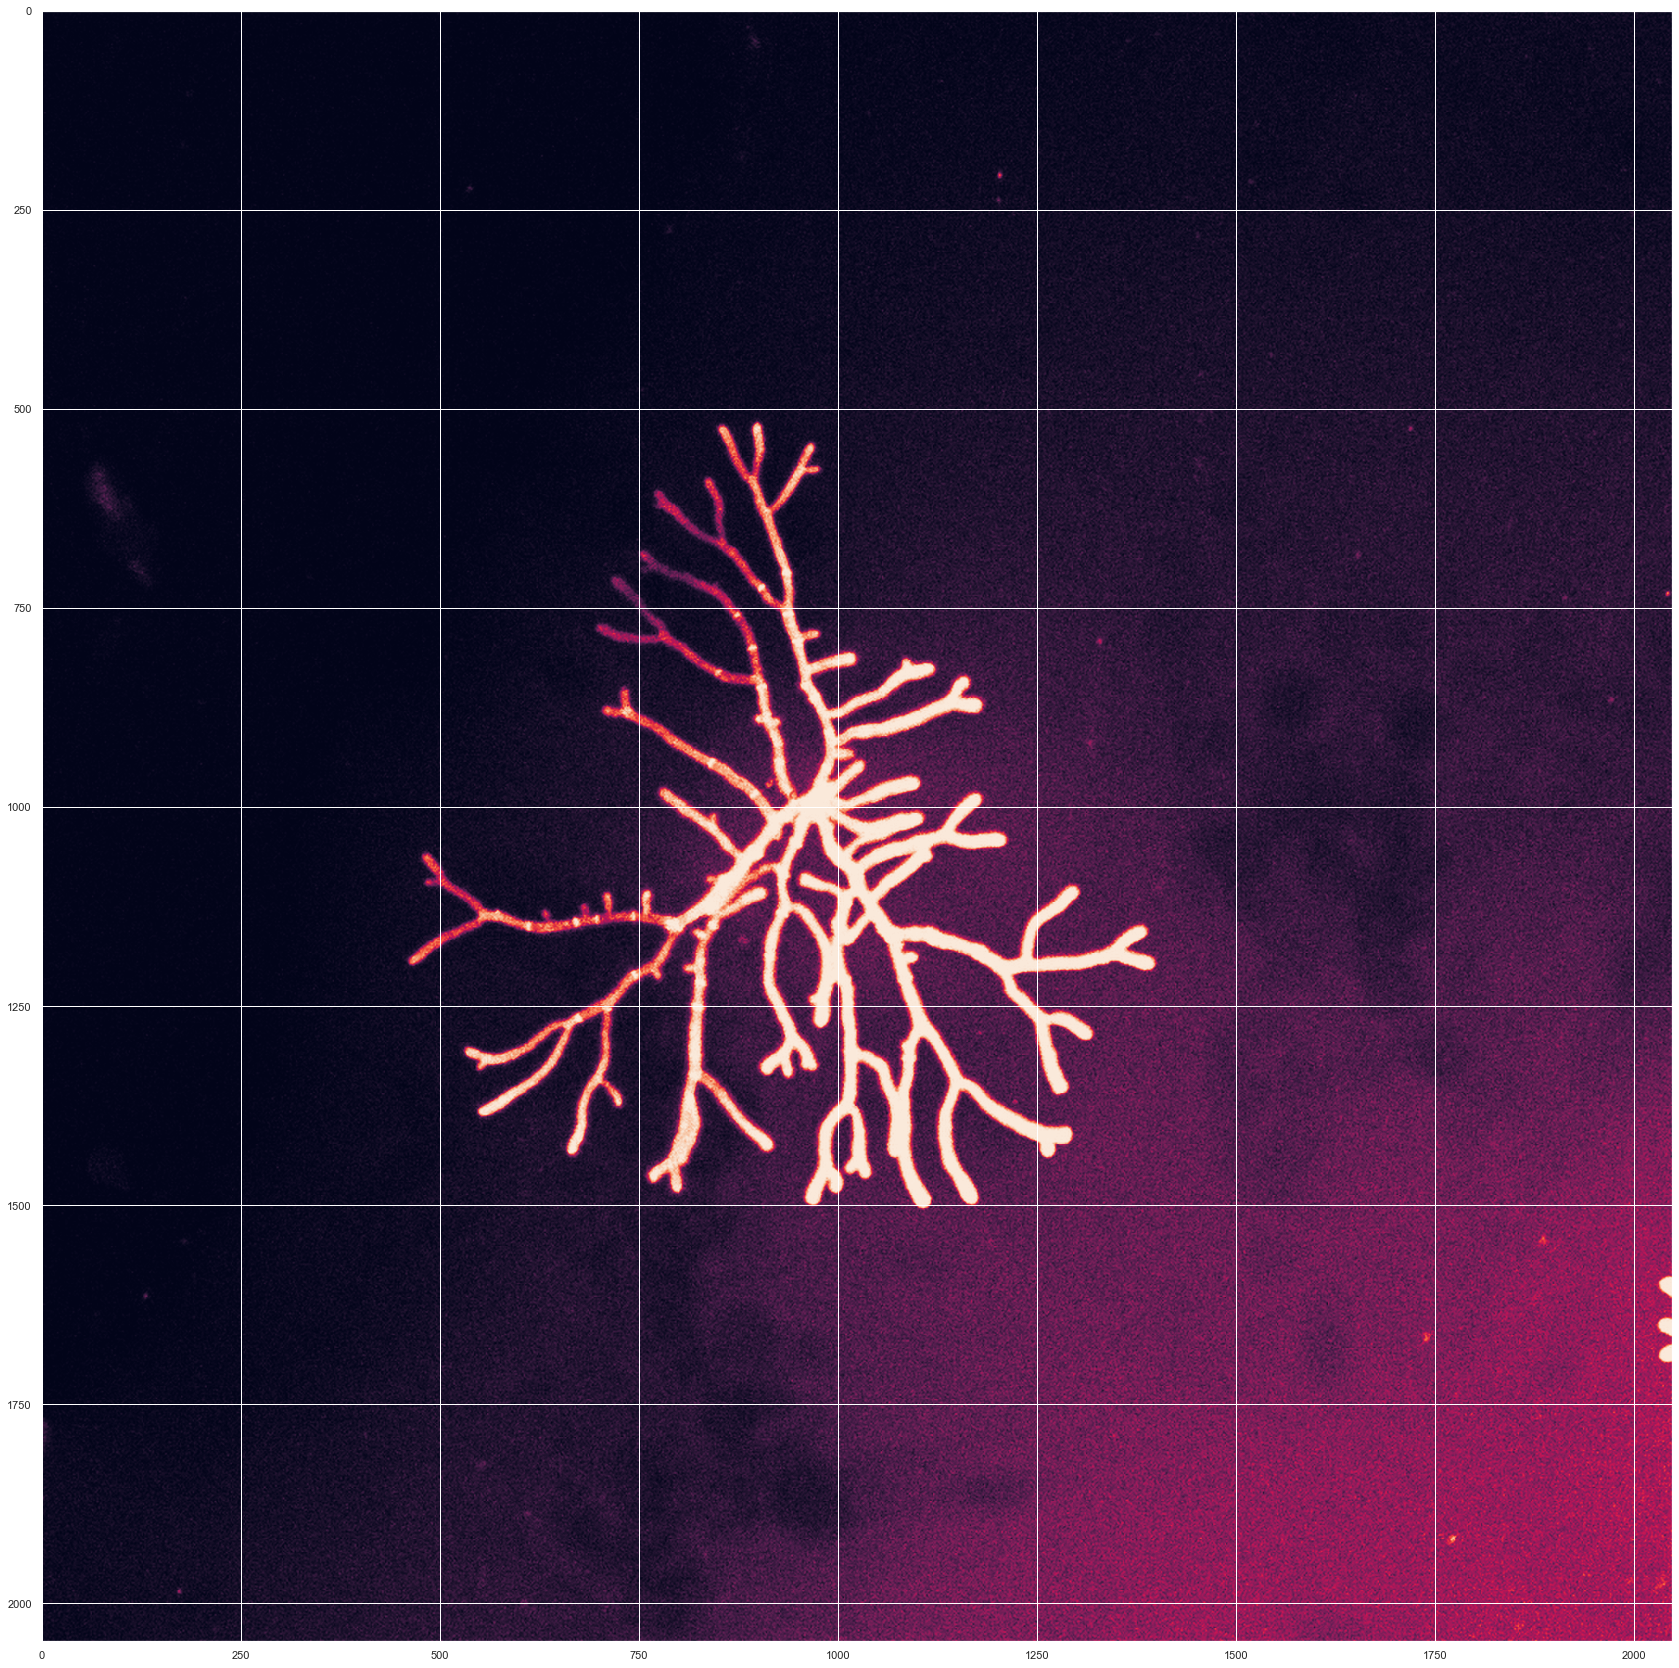

In [284]:

plt.figure(figsize=[40,30])
plt.imshow(fl_img)

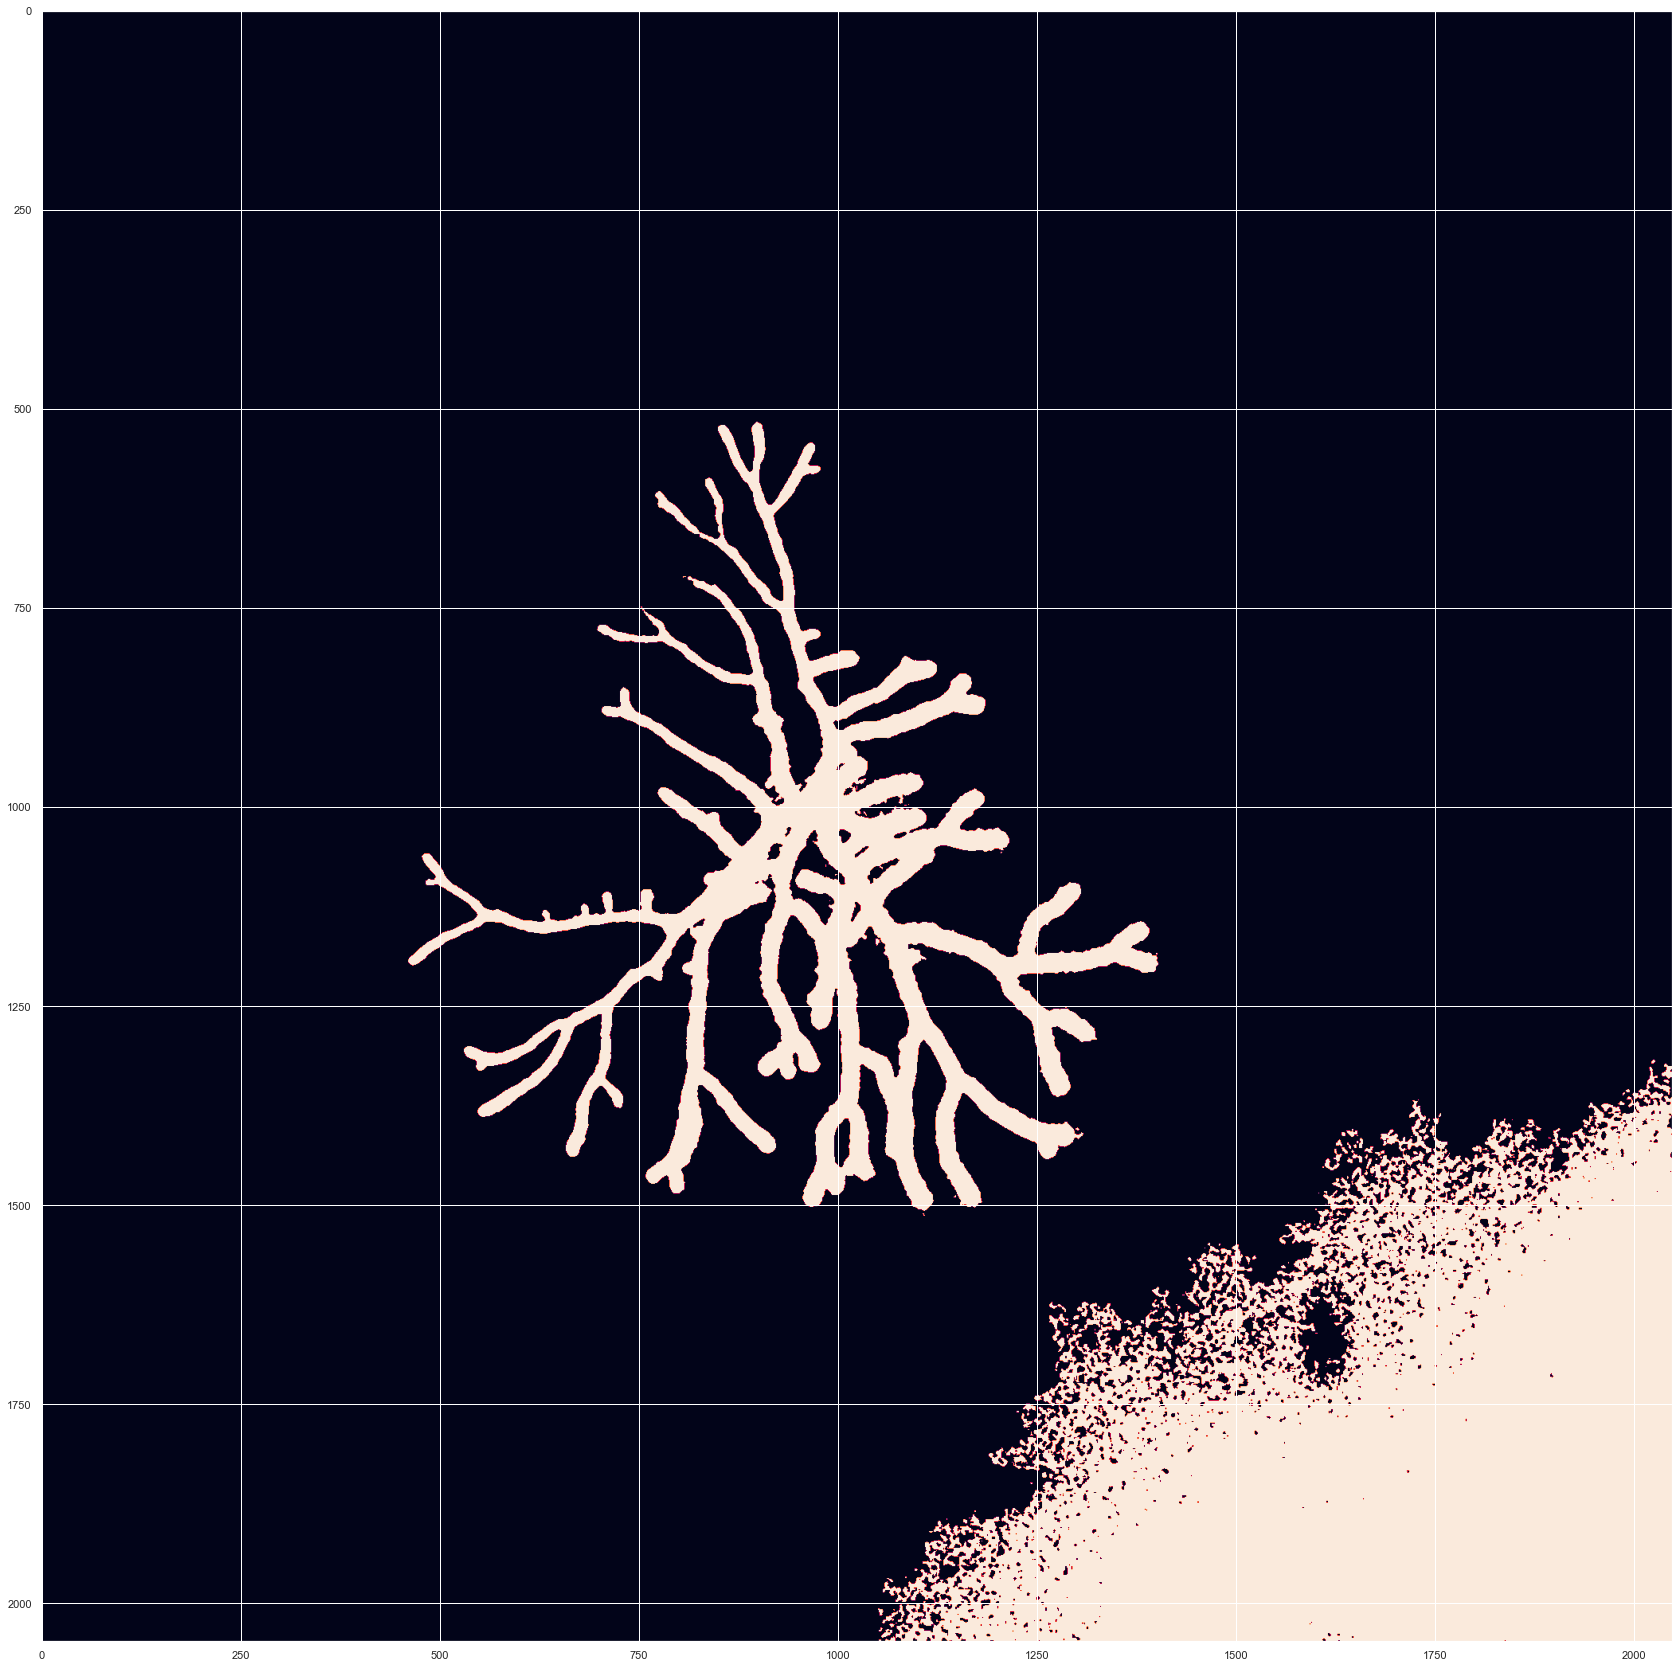

In [289]:
#threshold = img_overview.at[idx, "binary_threshold"]
threshold = 70

bin_img = fl_img.copy()
bin_img[bin_img >= threshold] = 255
bin_img[bin_img < threshold] = 0

bin_img = bin_img.astype(np.bool)

bin_img = morphology.remove_small_objects(bin_img, min_size=10000, connectivity=2)

bin_img = filters.median(bin_img, selem=morphology.square(5))

plt.figure(figsize=[40,30])
plt.imshow(bin_img)

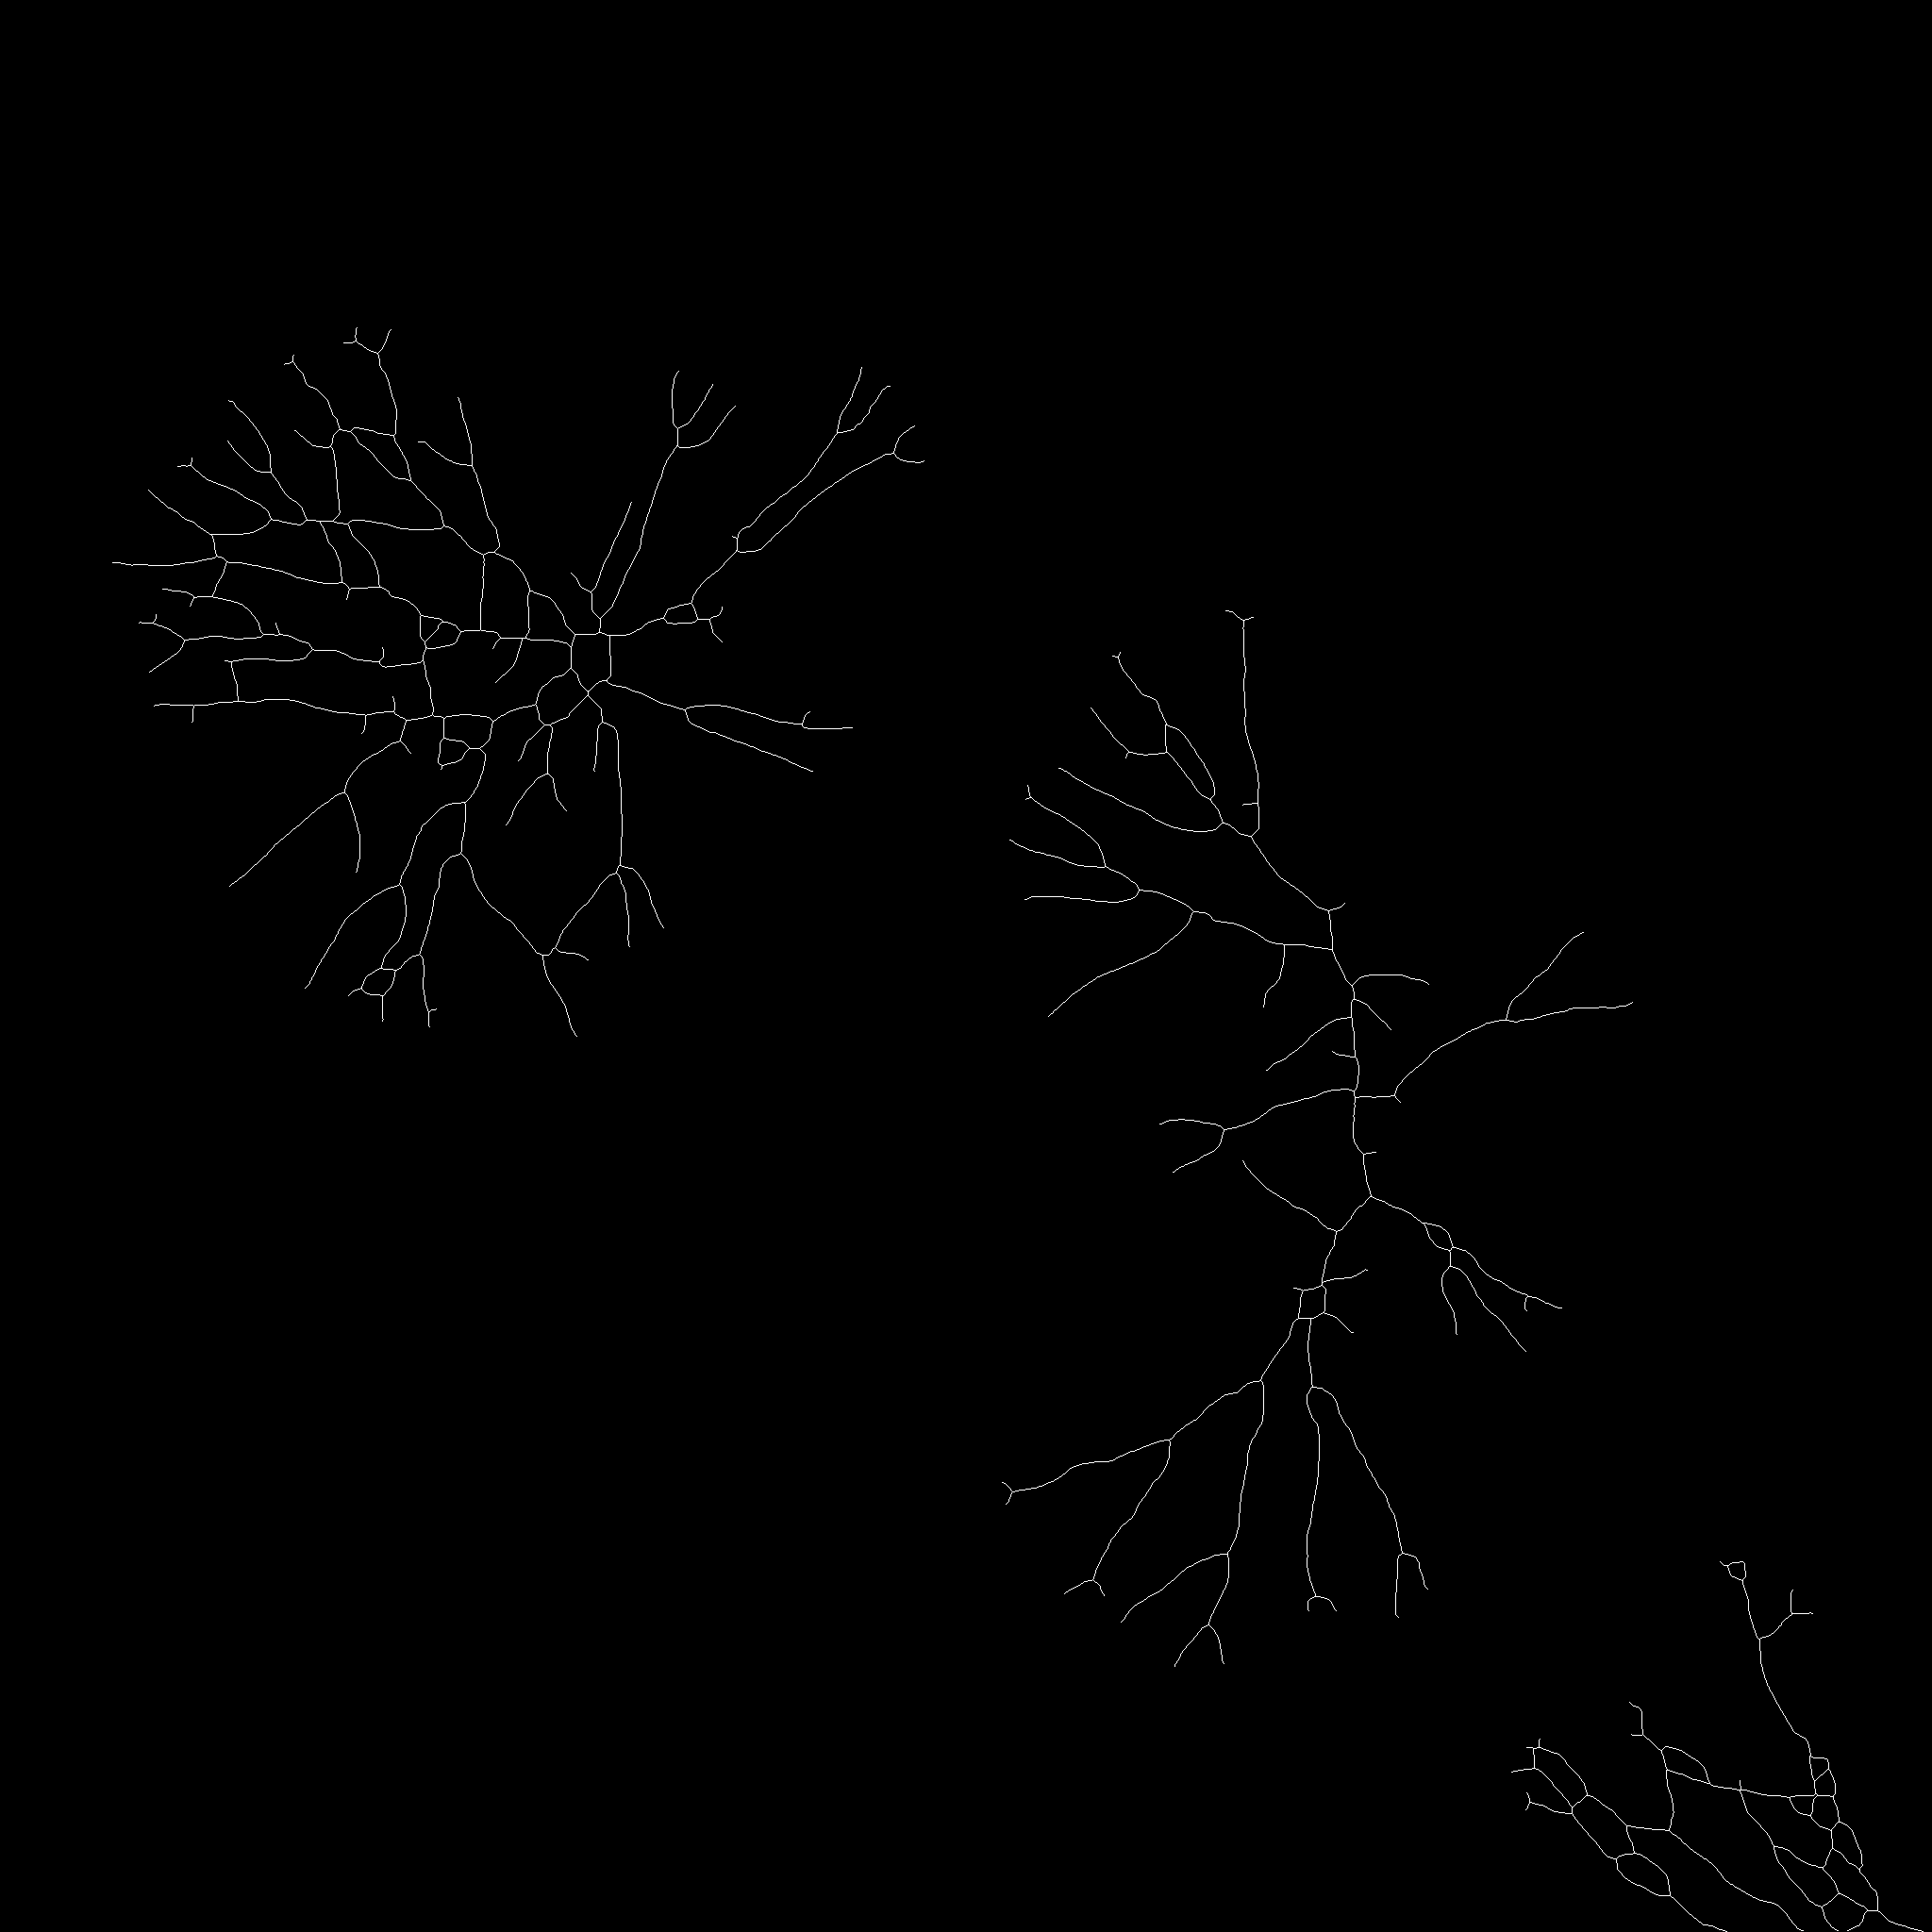

In [277]:
ske_img = morphology.skeletonize(bin_img)
ske_img = morphology.remove_small_objects(ske_img, min_size=1000, connectivity=2)


Image.fromarray(ske_img)

In [278]:


# build graph from skeleton
graph = sknw.build_sknw(ske_img)
    
# draw node by o
nodes = graph.nodes()
bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])


In [279]:
branch_mask = np.zeros(ske_img.shape, dtype=np.bool)
tip_mask = np.zeros(ske_img.shape, dtype=np.bool)

b_rad = 18
t_rad = 9
b_selem = morphology.disk(b_rad)
t_selem = morphology.disk(t_rad)
dims = ske_img.shape

for x,y in bs:
    x,y = int(x), int(y)
    
    # for edge cases, don't use selem, just square
    if dims[0] - x < b_rad + 1 or dims[1] - y < b_rad + 1 or x < b_rad or y < b_rad:
        branch_mask[x-b_rad:x+b_rad+1, y-b_rad:y+b_rad+1] = True
    else:
        # use binary or to avoid overwriting with 0's
        branch_mask[x-b_rad:x+b_rad+1, y-b_rad:y+b_rad+1] = branch_mask[x-b_rad:x+b_rad+1, y-b_rad:y+b_rad+1] | b_selem

for x,y in ts:
    x,y = int(x), int(y)
    
    # for edge cases, don't use selem, just square
    if dims[0] - x < t_rad + 1 or dims[1] - y < t_rad + 1 or x < t_rad or y < t_rad:
        tip_mask[x-t_rad:x+t_rad+1, y-t_rad:y+t_rad+1] = True
    else:
        # use binary or to avoid overwriting with 0's
        tip_mask[x-t_rad:x+t_rad+1, y-t_rad:y+t_rad+1] = tip_mask[x-t_rad:x+t_rad+1, y-t_rad:y+t_rad+1] | t_selem
    

branch_mask = branch_mask & bin_img
tip_mask = tip_mask & bin_img

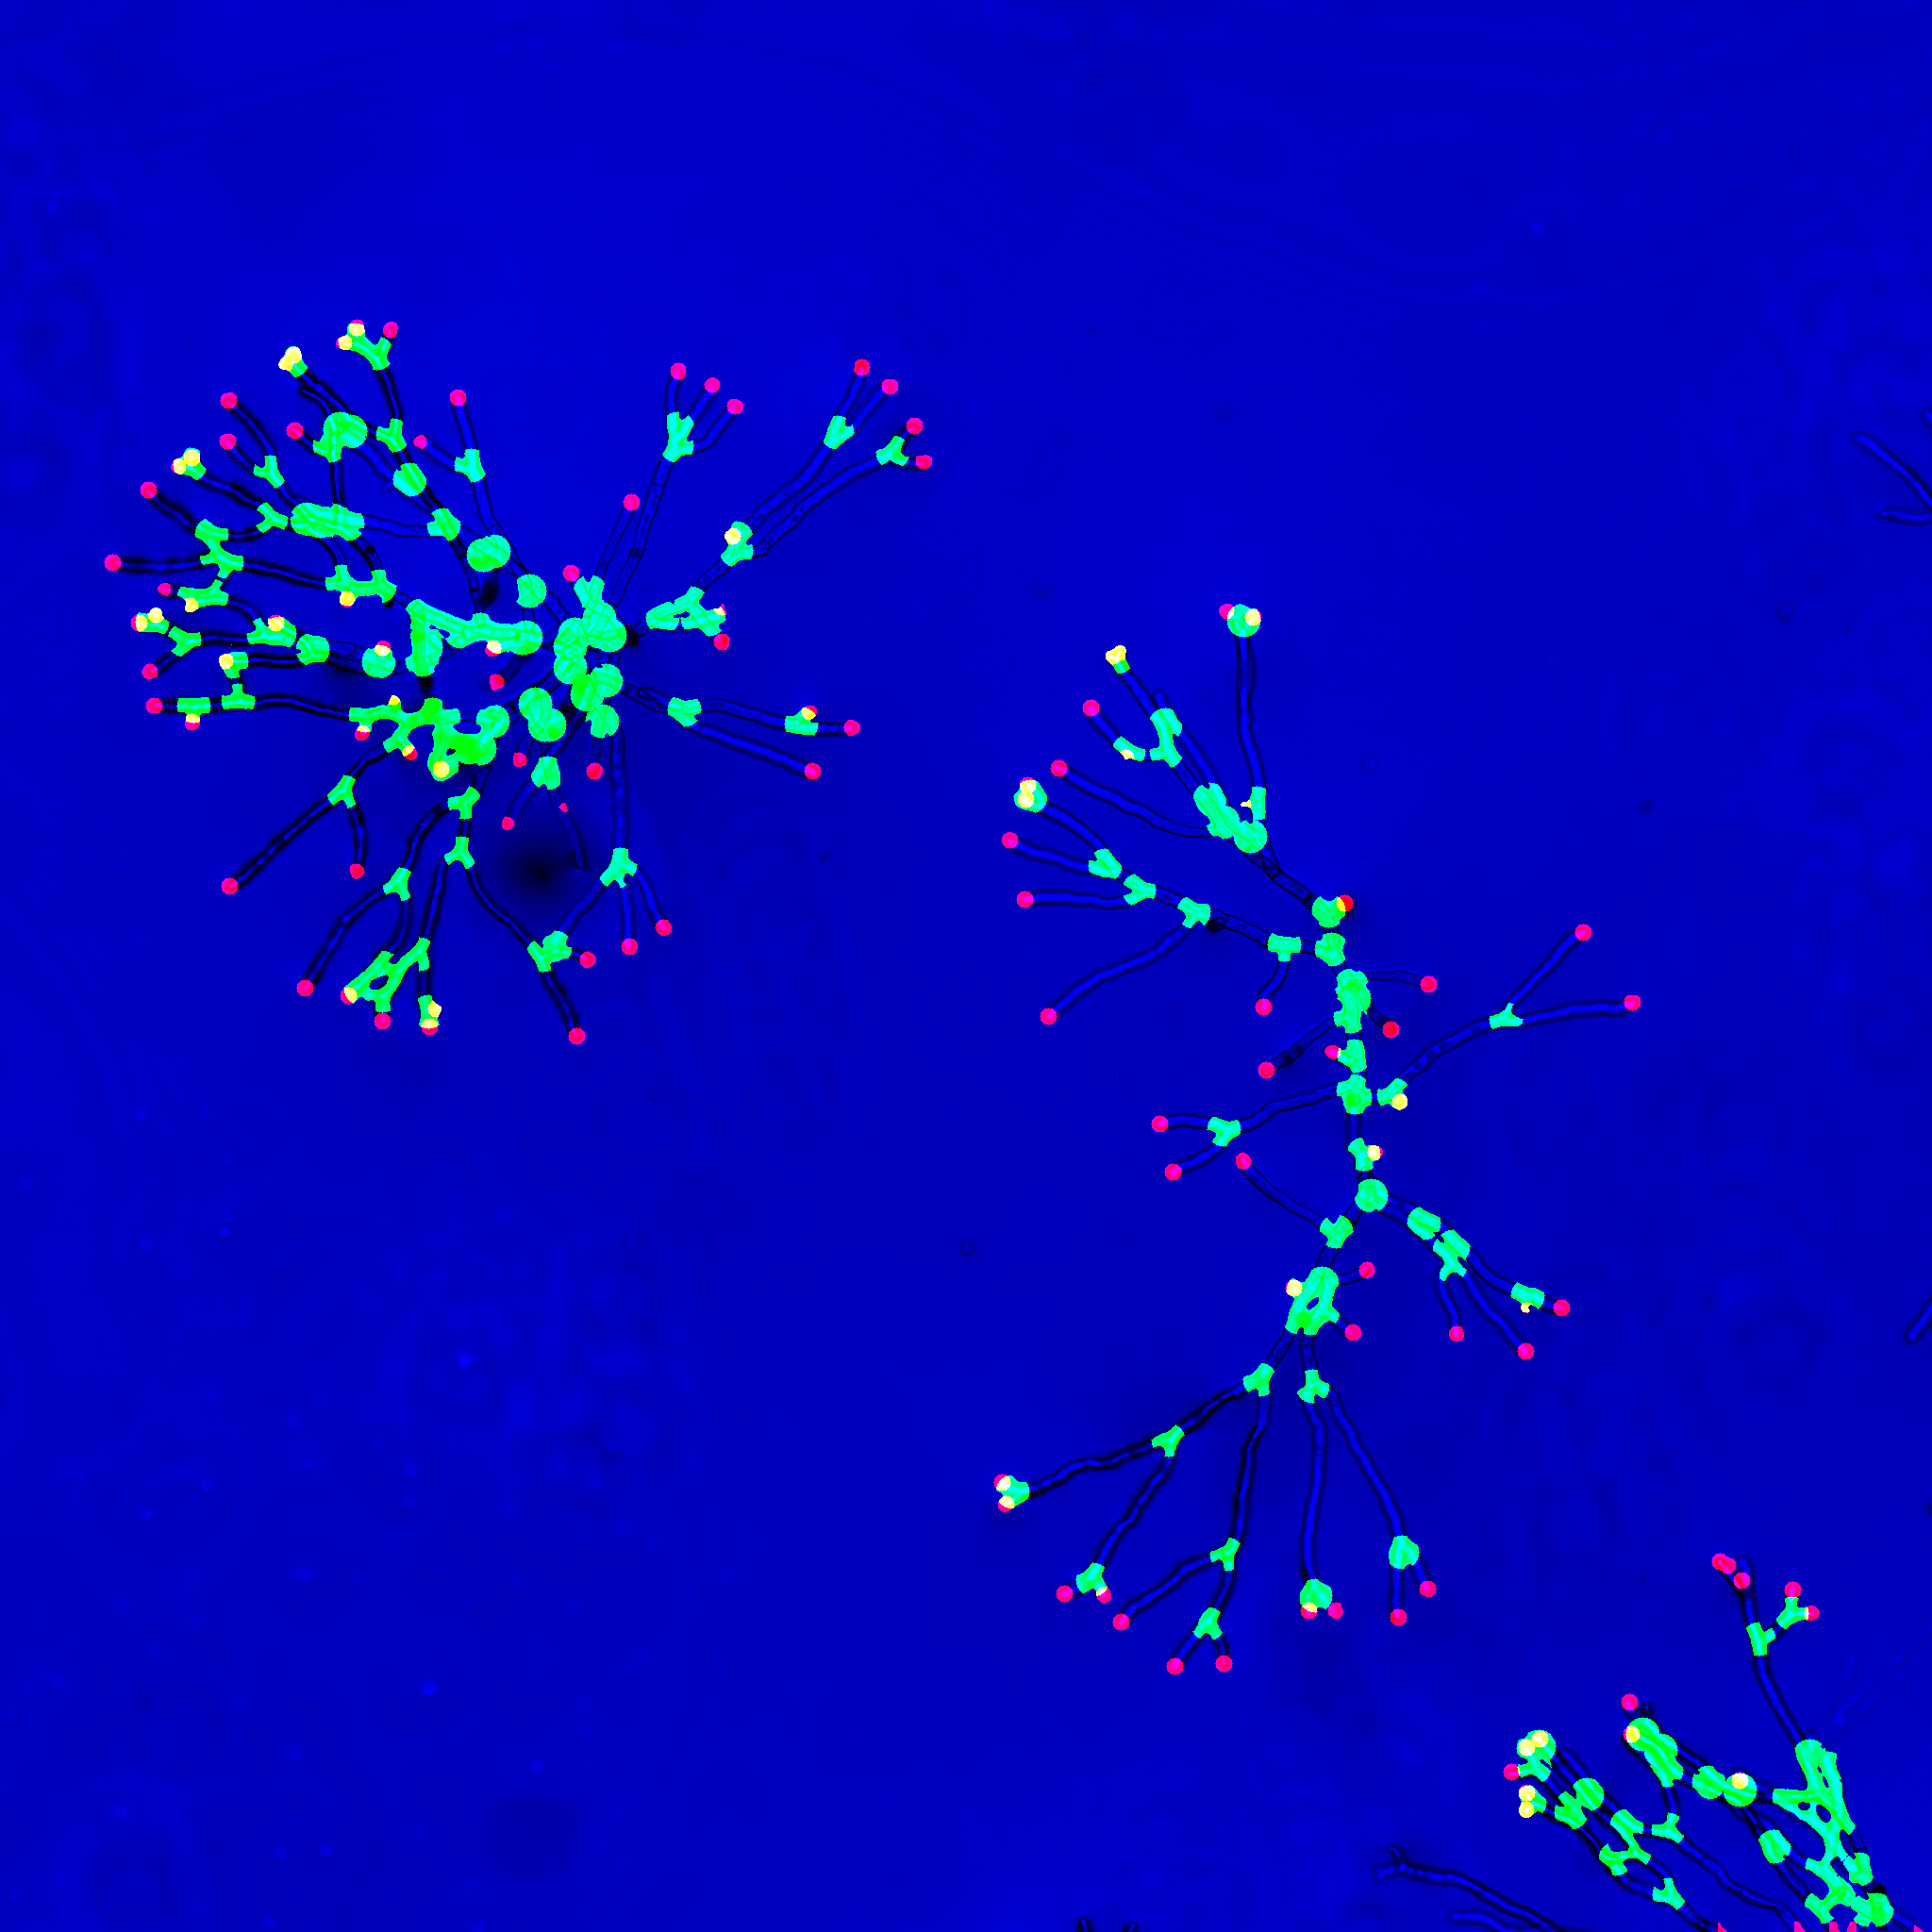

In [280]:
tip_mask = (tip_mask*255).astype(np.uint8)
branch_mask = (branch_mask*255).astype(np.uint8)

final_mask = np.array([tip_mask, branch_mask, bf_img])

Image.fromarray(final_mask.swapaxes(0,2).swapaxes(0,1))

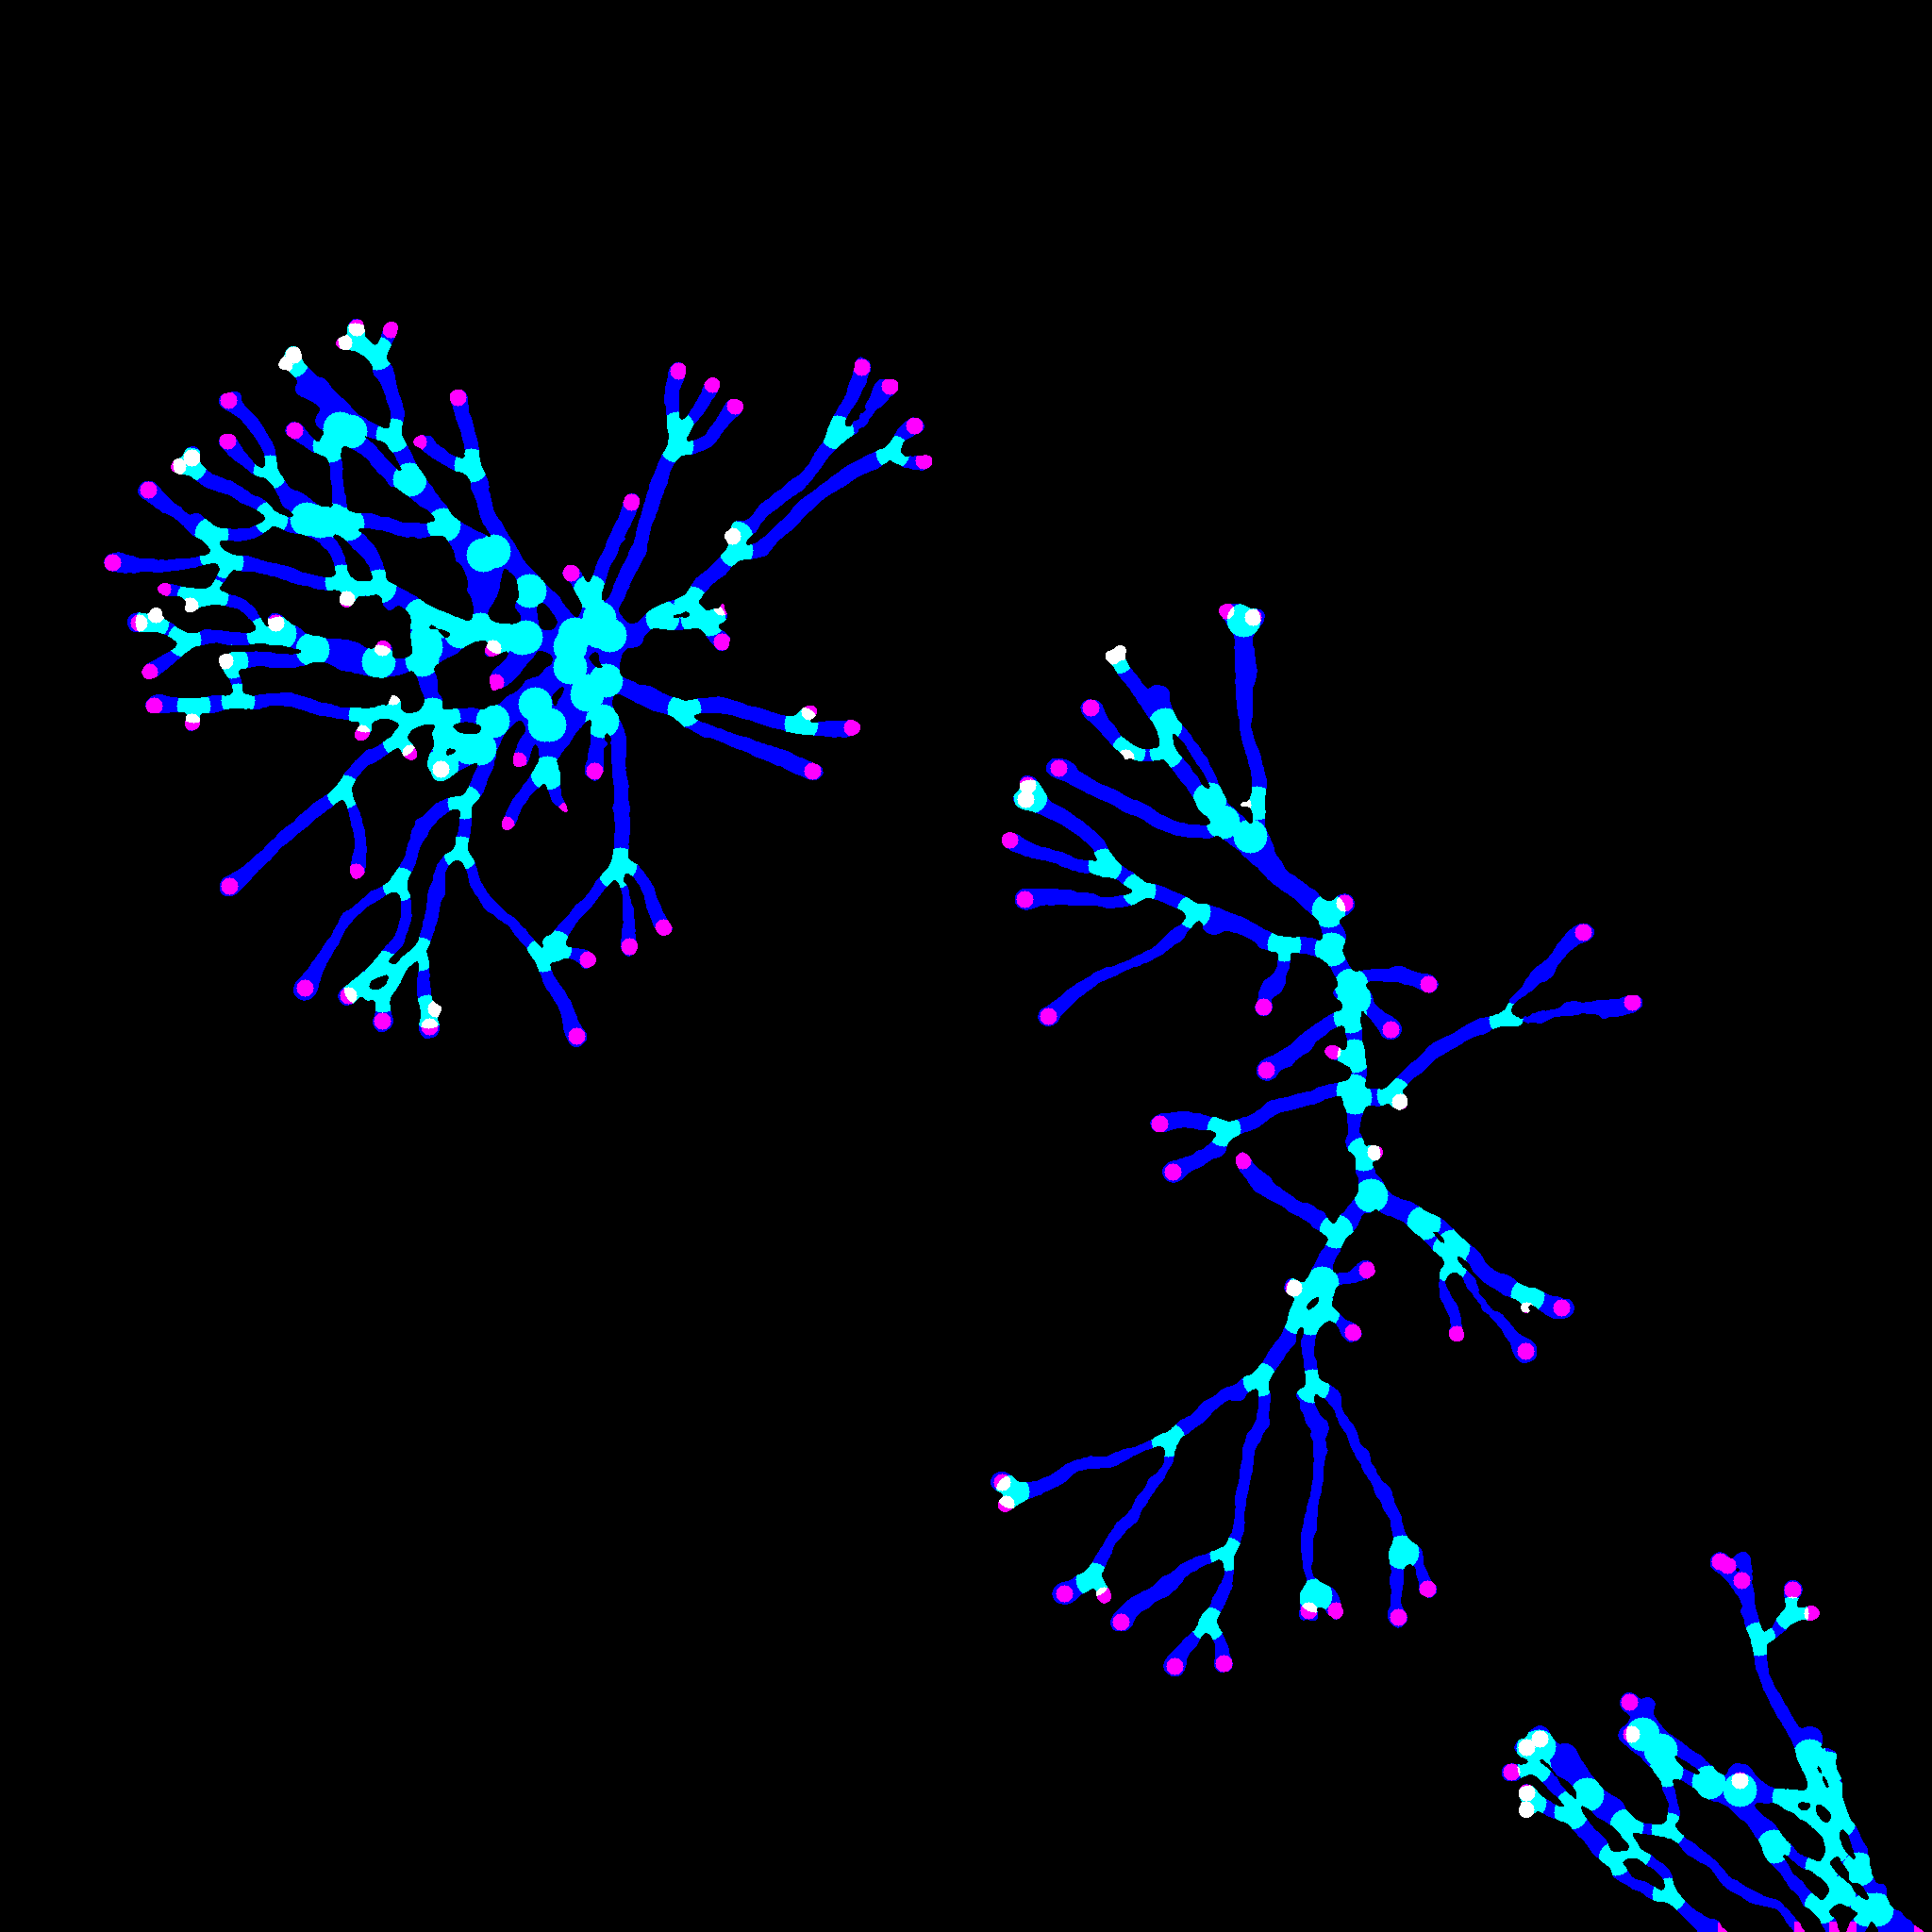

In [281]:
bin_img_256 = (bin_img*255).astype(np.uint8)

final_mask_2 = np.array([tip_mask, branch_mask, bin_img_256])

final_mask_2 = final_mask_2.swapaxes(0,2).swapaxes(0,1)

Image.fromarray(final_mask_2)

In [282]:
target_fname = str(img_overview.at[idx, "img_index"]) + "_target.jpg"

io.imsave(data+target_fname, final_mask_2)
img_overview.at[idx, "segmentation_fname"] = target_fname
img_overview.at[idx, "binary_threshold"] = threshold

img_overview.to_csv(data+overview_file, index=False)